In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1379)
import random

import pandas as pd
import os, time
import json

from sklearn.metrics.pairwise import paired_euclidean_distances

from src.clasp import *

### Load dataset

In [2]:
def load_TCPD_dataset():
    """ Load a TCPDBench dataset """
    desc_filename = "datasets/TCPD/desc.txt"
    desc_file = []

    with open(desc_filename, 'r') as file:
        for line in file.readlines(): desc_file.append(line.split(","))

    df = []

    for row in desc_file:
        (ts_name, window_size), change_points = row[:2], row[2:]

        #ts = np.loadtxt(fname=os.path.join('datasets/UCRCP/', ts_name + '.txt'), dtype=np.float64)
        filename = os.path.join('datasets/TCPD/', ts_name + '.json')
        with open(filename, "r") as fp:
            data = json.load(fp)

        if data["time"]["index"] != list(range(0, data["n_obs"])):
            raise NotImplementedError(
                "Time series with non-consecutive time axis are not yet supported."
            )

        mat = np.zeros((data["n_obs"], data["n_dim"]))
        for j, series in enumerate(data["series"]):
            mat[:, j] = series["raw"]
        

        # We normalize to avoid numerical errors.
        mat = (mat - np.nanmean(mat)) / np.sqrt(np.nanvar(mat))
        flatten_mat = [e for sublist in mat for e in sublist]
        
        df.append((ts_name, int(window_size), np.array([int(_) for _ in change_points]), flatten_mat))

    return pd.DataFrame.from_records(df, columns=["name", "window_size", "change points", "time_series"])


def load_sample_series():
    df = load_TCPD_dataset()
    #for idx, (name, window_size, cps, ts) in df.iterrows():
    df_sample = df[:1]
    #print('Sample dataset:', df_sample)
    ts_sample = df_sample.iloc[0]['time_series']
    #print('Sample series:', ts_sample)
    w_size_sample = df_sample.iloc[0]['window_size']
    #print('Sample window_size:', w_size_sample)
    n_cps_sample = df_sample.iloc[0]['change points']
    #print('Sample change points:', n_cps_sample)
    return ts_sample, w_size_sample, n_cps_sample

### Sliding windows and mean, std, dotProduct calculation

In [3]:
# the sliding windows for a time series and a window size
def sliding_window(ts, window_size):
    shape = ts.shape[:-1] + (ts.shape[-1] - window_size + 1, window_size)
    strides = ts.strides + (ts.strides[-1],)
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

# the sliding mean and std for a time series and a window size
def sliding_mean_std(TS, m):
    s = np.insert(np.cumsum(TS), 0, 0)
    sSq = np.insert(np.cumsum(TS ** 2), 0, 0)
    segSum = s[m:] - s[:-m]
    segSumSq = sSq[m:] - sSq[:-m]
    movmean = segSum / m
    movstd = np.sqrt(segSumSq / m - (segSum / m) ** 2)
    return [movmean, movstd]

# the sliding dot product between a query subsequence and a time series
def slidingDotProduct(query, ts):
    m = len(query)
    n = len(ts)

    ts_add = 0
    if n % 2 == 1:
        ts = np.insert(ts, 0, 0)
        ts_add = 1

    q_add = 0
    if m % 2 == 1:
        query = np.insert(query, 0, 0)
        q_add = 1

    query = query[::-1]
    query = np.pad(query, (0, n - m + ts_add - q_add), 'constant')
    trim = m - 1 + ts_add
    dot_product = fft.irfft(fft.rfft(ts) * fft.rfft(query))
    return dot_product[trim:]

### Distance calculation

In [17]:
# kNN indices with dot-product / no-loops for a time series, a window size and k neighbours
def compute_distances_iterative(TS, m, k):
    l = len(TS) - m + 1
    knns = np.zeros(shape=(l, k), dtype=np.int64)
    knns_distance = np.zeros(shape=(l, k), dtype=np.int64)

    dot_prev = None
    means, stds = sliding_mean_std(TS, m)

    for order in range(0, l):
        # first iteration O(n log n)
        if order == 0:
            dot_first = slidingDotProduct(TS[:m], TS)
            # dot_first = np.dot(X[order,:], X.T)
            dot_rolled = dot_first
        # O(1) further operations
        else:
            dot_rolled = np.roll(dot_prev, 1) + TS[order + m - 1] * TS[m - 1:l + m] - TS[order - 1] * np.roll(TS[:l], 1)
            dot_rolled[0] = dot_first[order]

        x_mean = means[order]
        x_std = stds[order]

        dist = 2 * m * (1 - (dot_rolled - m * means * x_mean) / (m * stds * x_std))
#         print('dist:', dist)
        
        # self-join: exclusion zone
        trivialMatchRange = (int(max(0, order - np.round(m / 2, 0))), int(min(order + np.round(m / 2 + 1, 0), l)))
        dist[trivialMatchRange[0]:trivialMatchRange[1]] = np.inf
        #print('dist:', dist)
        
        idx = np.argpartition(dist, k)
        #print('idx:', idx)

        knns[order, :] = idx[:k]
#         knns_distance[order, :] = dist[:k]
        dot_prev = dot_rolled
#     print('dist', dist)
#     print('idx', idx)
#     print('knns:', knns)
#     print('knns_distance:', knns_distance)
    return knns
    
def compute_distances_windows(ts, w_size, k):
    KNNs = []
    for i in range(k, len(ts)-w_size+1):
        #print(np.array(ts[:w_size+i]))
        KNNs.append(compute_distances_iterative(ts[:w_size+i], w_size, k))
    #print(KNNs)
    return KNNs

# ts =  np.array([0, 5, 1, 4, 10, -2, 3, 8, 7, 9, 2])
# ts_small = np.array([0, 5, 1, 10, -2, 7, 8])
# w_size = 3
# k = 3
# knns = compute_distances_iterative(ts_small, w_size, k)
# compute_distances_windows(ts_small, w_size, k)

def majority_knns(ts, w_size, knns, k):
    
    return majority_knns

### Maximum gap calculation

In [41]:
def extract_distance_by_idx(TS, w_size, idx):
    sliding_mean_std(TS, w_size)
    means, stds = sliding_mean_std(TS, w_size)
    mean_idx = []
    std_idx = []
    for i in idx:
        mean_idx.append(means[i])
        std_idx.append(stds[i])
    return mean_idx, std_idx

        
def largest_gap(NNs):
    """find consecutive difference"""
    #differences = list(NNs.values())
    gaps = np.diff(NNs)
    #print('gaps:', gaps)
    abs_gaps = [abs(e) for e in gaps]
    print('abs_gaps:', abs_gaps)
    """here we find the maximum value of an nd-array"""
    max_gap = np.amax(abs_gaps)
    return max_gap    

def extract_largest_gap_for_all_windows_from_knns(ts, knns):
    max_gaps = []
    for idx in knns:
        #print('idx:', idx)
        mean_idx, std_idx = extract_distance_by_idx(ts, w_size, idx)
        mean_idx.append(mean_idx[0])
        max_gap = largest_gap(mean_idx)
        max_gaps.append(max_gap)
        print('mean_idx:', mean_idx)
        #print('std_idx:', std_idx)
        #print('max_gap:', max_gap)
    return max_gaps
# max_gaps = extract_largest_gap_for_all_windows_from_knns(knns)
# print('max_gaps:', max_gaps)

### Test with real data (TCPD)

In [31]:
ts, w_size, n_cps = load_sample_series()
print('ts size:', len(ts))
ts = np.array(ts)

ts size: 313


KNNs in total: 2
head KNNs: [array([[0, 3, 2],
       [0, 1, 3],
       [0, 1, 2],
       [0, 1, 2]]), array([[2, 4, 3],
       [3, 4, 0],
       [3, 4, 0],
       [3, 0, 2],
       [1, 0, 2]])]
abs_gaps: [array([3., 2.]), array([3.33333333, 0.33333333]), array([3.33333333, 2.33333333]), array([3.33333333, 2.33333333]), array([3., 2.])]
mean_idx: [array([2., 5., 3.]), array([2.        , 5.33333333, 5.        ]), array([2.        , 5.33333333, 3.        ]), array([2.        , 5.33333333, 3.        ]), array([2., 5., 3.])]
abs_gaps: [array([1.33333333, 0.66666667]), array([0.66666667, 2.33333333]), array([0.66666667, 2.33333333]), array([3., 1.]), array([3.33333333, 1.        ]), array([1.33333333, 0.66666667])]
mean_idx: [array([3.        , 4.33333333, 5.        ]), array([5.        , 4.33333333, 2.        ]), array([5.        , 4.33333333, 2.        ]), array([5., 2., 3.]), array([5.33333333, 2.        , 3.        ]), array([3.        , 4.33333333, 5.        ])]
max_gaps: [3.3333333333

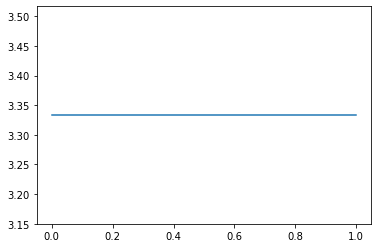

In [45]:
ts =  np.array([0, 5, 1, 4, 10, -2, 3, 8, 7, 9, 2])
ts_small = np.array([0, 5, 1, 10, -2, 7, 8])
w_size = 3
k = 3

KNNs = compute_distances_windows(ts_small, w_size, k)
print('KNNs in total:', len(KNNs))
print('head KNNs:', KNNs)
max_gaps = extract_largest_gap_for_all_windows_from_knns(ts_small, KNNs)
print('max_gaps:', max_gaps)

plt.plot(range(len(max_gaps)), max_gaps)
plt.show()